In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scoring as sc #pip install scoring

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as lr
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,log_loss

In [130]:
df=pd.read_csv('gc.csv')
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# Boxplot

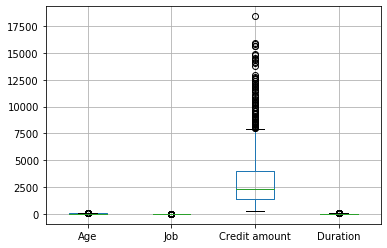

In [3]:
df.boxplot()

# correlation matrix

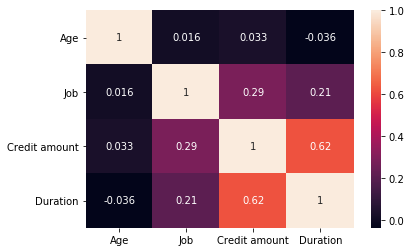

In [87]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Yet to handle null values

In [84]:
df.isnull().sum()
#df['Age'].fillna(df['Age'].mean()) //use fillna method


0       NaN
1      22.0
2      49.0
3      45.0
4      53.0
       ... 
995    31.0
996    40.0
997    38.0
998    23.0
999    27.0
Name: Age, Length: 1000, dtype: float64

# Missing values plot

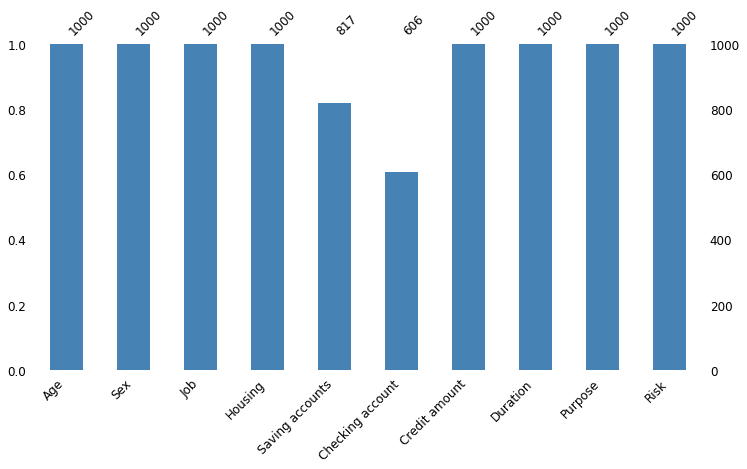

In [65]:
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')

# (GET DUMMIES) Encode categorical values to columns 

In [131]:
df=pd.get_dummies(df)
df.drop(['Risk_good'],axis=1,inplace=True)

df.rename({'Risk_bad':'output'},axis=1,inplace=True)
df.head()

#To make 0 or 1
#df['col1'] = df['col1'].apply(lambda x: 1 if x <= period else 0)

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,output
0,67,2,1169,6,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,22,2,5951,48,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
2,49,1,2096,12,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,45,2,7882,42,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,53,2,4870,24,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


# Remove Features with constant values (less variance)

In [7]:
from sklearn.feature_selection import VarianceThreshold
print("features before removing constant columns",len(df.columns))
var_t=VarianceThreshold(threshold=0)
var_t.fit_transform(df)

print("features after removing constant columns",len(df.columns[var_t.get_support()]))

features before removing constant columns 25
features after removing constant columns 25


# Remove Less correlated Features

In [8]:
print('consider features with correlation more than 0.05 only')
print('===================================================')
print("Original Features",len(df.columns))
corr=df.corr()
corr_target=abs(corr['output'])

relevant_features=corr_target[corr_target>0.05] 
print("Relevant Features",len(relevant_features))


consider features with correlation more than 0.05 only
Original Features 25
Relevant Features 15


# Recursive Feature Elimination

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# Feature extraction
X = df.loc[:, df.columns != 'output']
Y= df.loc[:,'output']

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=7)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_),X.columns)
print("Feature Ranking: %s" % (fit.ranking_))

temp=pd.DataFrame(columns=['features','active'])
temp['features']=X.columns
temp['active']=fit.support_
relevant_features=temp[temp['active']]
print("\n\nList of top %s features" % (fit.n_features_))
print("======================")
relevant_features

Num Features: 7
Selected Features: [False False False False False False False  True False  True  True False
 False  True  True  True False False False  True False False False False] Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others'],
      dtype='object')
Feature Ranking: [17 16 18 15  4  8 10  1 11  1  1  7  2  1  1  1  5 12 14  1  9  3  6 13]


List of top 7 features


,features,active
7,Housing_own,True
9,Saving accounts_little,True
10,Saving accounts_moderate,True
13,Checking account_little,True
14,Checking account_moderate,True
15,Checking account_rich,True
19,Purpose_education,True


# Random forest feature importances (with robust permutation)

In [112]:

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x_test, y_test)))
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, x_train, y_train):
    return r2_score(y_train, rf.predict(x_train))

perm_imp_rfpimp = permutation_importances(rf, x_train, y_train, r2)

perm_imp_rfpimp

R^2 Training Score: 0.88 
OOB Score: 0.13 
R^2 Validation Score: 0.12


,Importance
Feature,
Checking account_little,0.473859
Credit amount,0.389429
Duration,0.387928
Age,0.296704
Checking account_moderate,0.277261
Saving accounts_little,0.140036
Job,0.108226
Purpose_car,0.037296
Purpose_business,0.036265


# PCA with scaled data

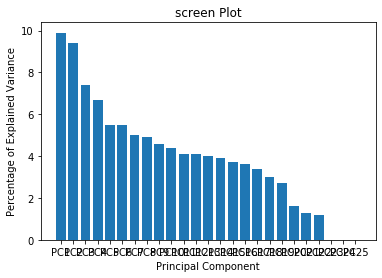

Top 15 important features
 Sex_female                     0.502448
Sex_male                       0.502448
Housing_rent                   0.300307
Credit amount                  0.297874
Duration                       0.273733
Age                            0.213512
Housing_free                   0.203898
Purpose_furniture/equipment    0.187075
Job                            0.180293
Purpose_business               0.124031
Purpose_car                    0.117995
Housing_own                    0.114593
Purpose_vacation/others        0.110259
Saving accounts_little         0.085676
Checking account_little        0.084363
dtype: float64


In [10]:
scaled_data = preprocessing.scale(df)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals =1 )
labels = ['PC' +str(x) for x in range(1,len(per_var)+1)]

## Plotting the scree plot to explain the maximum variance 
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('screen Plot')
plt.bar(x = range(1, len(per_var)+1), height = per_var,tick_label = labels)
plt.show()
# All of the variance is being explained with PC1 itself 
loading_scores = pd.Series(pca.components_[0], index=df.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_15_Features = sorted_loading_scores[0:15]
print('Top 15 important features\n====================\n',top_15_Features)

# PCA with algorithm

In [11]:
scaled_data = preprocessing.scale(df)
pca = PCA(n_components=10,random_state=10)
pca_data = pca.fit_transform(scaled_data)
x_train,x_test,y_train,y_test = train_test_split(pca_data, df['output'], test_size=0.3, random_state=10,stratify=df['output'])
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500,max_depth=2, random_state=0)
model=clf.fit(x_train, y_train)
prediction = model.predict(x_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

train_predictions = model.predict_proba(x_test)
ll = log_loss(y_test, train_predictions)
print("Log_loss:",ll)

print('\nCONFUSION MATRIX')
print('=======================')
print('\n',confusion_matrix(y_test, prediction))
print('\nCLASSIFICATION REPORT')
print('=======================')
print(classification_report(y_test, prediction))
print('================================')
print('Total no of TestSamples taken :', confusion_matrix(y_test, prediction).sum())
print('================================')

Accuracy: 79.0%
Log_loss: 0.47339876797670816

CONFUSION MATRIX

 [[207   3]
 [ 60  30]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       210
           1       0.91      0.33      0.49        90

    accuracy                           0.79       300
   macro avg       0.84      0.66      0.68       300
weighted avg       0.82      0.79      0.75       300

Total no of TestSamples taken : 300


# Train Test split 

In [12]:
x_train,x_test,y_train,y_test= train_test_split(df.iloc[:,0:24], df['output'], test_size=0.3, random_state=10,stratify=df['output'])


# Evaluation Metrics

Accuracy: 70.0%
Log_loss: 0.575288099887779

CONFUSION MATRIX


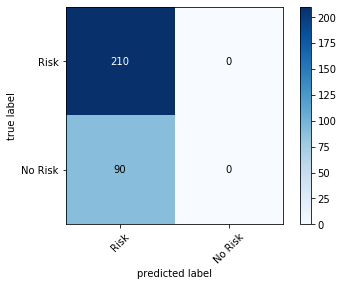


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       210
           1       0.00      0.00      0.00        90

    accuracy                           0.70       300
   macro avg       0.35      0.50      0.41       300
weighted avg       0.49      0.70      0.58       300

Total no of TestSamples taken : 300


In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500,max_depth=2, random_state=0)
model=clf.fit(x_train, y_train)
prediction = model.predict(x_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

train_predictions = model.predict_proba(x_test)
ll = log_loss(y_test, train_predictions)
print("Log_loss:",ll)

print('\nCONFUSION MATRIX')
print('=======================')

from mlxtend.plotting import plot_confusion_matrix
multiclass =confusion_matrix(y_test, prediction)

class_names = ['Risk','No Risk']

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names)
plt.show()

print('\nCLASSIFICATION REPORT')
print('=======================')
print(classification_report(y_test, prediction))
print('================================')
print('Total no of TestSamples taken :', confusion_matrix(y_test, prediction).sum())
print('================================')

# TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    '''Doc1 contact to server chat and reach out our centre''',
    '''Doc2 About us. We deliver Artificial Intelligence & Machine Learning
       solutions to solve business challenges.''',
    '''Doc3 Contact information. Email [martin davtyan at filament dot ai]
       if you have any questions''',
    '''Doc4 Filament Chat. A framework for building and maintaining a scalable
       chatbot capability''',
    
]
stoplist = set('for a of the and to in'.split())
vectorizer = TfidfVectorizer(stop_words=stoplist)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

query = 'contact email to chat to martin'
query_vector = vectorizer.transform([query]).todense()
print('\nVector form of Query\n==================\n Query->%s\n\n Query vector->%s'%(query,query_vector))

['about', 'ai', 'any', 'artificial', 'at', 'building', 'business', 'capability', 'centre', 'challenges', 'chat', 'chatbot', 'contact', 'davtyan', 'deliver', 'doc1', 'doc2', 'doc3', 'doc4', 'dot', 'email', 'filament', 'framework', 'have', 'if', 'information', 'intelligence', 'learning', 'machine', 'maintaining', 'martin', 'our', 'out', 'questions', 'reach', 'scalable', 'server', 'solutions', 'solve', 'us', 'we', 'you']

Vector form of Query
 Query->contact email to chat to martin

 Query vector->[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.43779123 0.
  0.43779123 0.         0.         0.         0.         0.
  0.         0.         0.55528266 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.55528266 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]


In [34]:
#https://medium.com/filament-ai/making-text-search-learn-from-feedback-4fe210fd87b0
from sklearn.metrics.pairwise import cosine_similarity

doc_vectors = vectorizer.transform(corpus)
similarity = cosine_similarity(query_vector, doc_vectors)
print('simalarity score of the Query w.r.t documents in corpus->\n',similarity)
ranks = (-similarity).argsort(axis=None)
ranks
most_relevant_doc = corpus[ranks[0]]
print('\n\nMost relevant document==>\n',most_relevant_doc)

simalarity score of the Query w.r.t documents in corpus->
 [[0.25649872 0.         0.38572321 0.12021882]]


Most relevant document==>
 Doc3 Contact information. Email [martin davtyan at filament dot ai]
       if you have any questions


In [42]:
#https://medium.com/filament-ai/making-text-search-learn-from-feedback-4fe210fd87b0
feedback = {
        'who makes chatbots': [(2, 0.), (0, 1.), (1, 1.), (0, 1.)],
        'about page': [(0, 1.)],
        'chatbots are handy tool':[(2,0.),(0,1.),(1,1.)]
}
similarity = cosine_similarity(vectorizer.transform(['who makes chatbots']), doc_vectors)
ranks = (-similarity).argsort(axis=None)
corpus[ranks[0]]

'Doc1 contact to server chat and reach out our centre'

In [148]:
df=pd.read_csv('gc.csv')
df=pd.get_dummies(df)
df.drop(['Risk_good'],axis=1,inplace=True)
df.rename({'Risk_bad':'output'},axis=1,inplace=True)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def accuracy(xtrain,xtest):
    xtrain=xtrain
    xtest=xtest
#     print('For features count %s'%(num_of_features)
    clf = RandomForestClassifier(n_estimators=500,max_depth=2, random_state=0)
    model=clf.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
    train_predictions = model.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log_loss:",ll)

target=df['output']    
for i in range(3,23):
    print('Report for no of features %s'%(i))
    df1=df.iloc[:,0:i]
    print(df1.columns)
    x_train,x_test,y_train,y_test= train_test_split(df1, target, test_size=0.3, random_state=10,stratify=target)
    print(accuracy(x_train,x_test))
          
# # Feature extraction
# X = df.loc[:, df.columns != 'output']
# Y= df.loc[:,'output']

# model = LogisticRegression()
# rfe = RFE(model, n_features_to_select=7)
# fit = rfe.fit(X, Y)
# print("Num Features: %s" % (fit.n_features_))
# print("Selected Features: %s" % (fit.support_),X.columns)
# print("Feature Ranking: %s" % (fit.ranking_))

# temp=pd.DataFrame(columns=['features','active'])
# temp['features']=X.columns
# temp['active']=fit.support_
# relevant_features=temp[temp['active']]
# print("\n\nList of top %s features" % (fit.n_features_))
# print("======================")
# relevant_features




Report for no of features 3
Index(['Age', 'Job', 'Credit amount'], dtype='object')
Accuracy: 70.33%
Log_loss: 0.5953186483167244
None
Report for no of features 4
Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')
Accuracy: 70.67%
Log_loss: 0.5811403112699944
None
Report for no of features 5
Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female'], dtype='object')
Accuracy: 70.0%
Log_loss: 0.5823144343789342
None
Report for no of features 6
Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male'], dtype='object')
Accuracy: 70.33%
Log_loss: 0.5831444005383081
None
Report for no of features 7
Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free'],
      dtype='object')
Accuracy: 70.33%
Log_loss: 0.5849447767969587
None
Report for no of features 8
Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own'],
      dtype='object')
Accuracy: 70.33%
Log_lo